In [1]:
import chipscvn.utils as utils
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.evaluators as evaluators

In [2]:
utils.gpu_setup()  # Setup the GPU's

conf = config.process_config("config/classification.yml")
data_loader = data.DataLoader(conf)
model = utils.get_model(conf)
model.load()
evaluator = utils.get_evaluator(conf)
evaluator.run()
labels, predictions = evaluators.predict(data_loader.test_data(), model)

---  4 Physical GPUs, 4 Logical GPUs ---
   2500/Unknown - 111s 44ms/step - loss: 1.0471 - accuracy: 0.6189[1.0471352151393891, 0.618875]
--- 76.7010772228241 seconds to test model ---


<Figure size 1152x720 with 0 Axes>

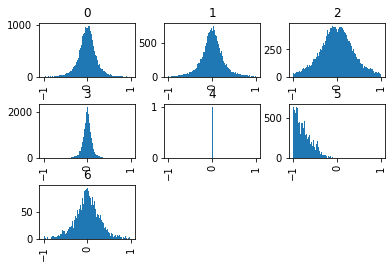

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
labels.hist(column='dirTheta', by='type', bins=100, range=[-1,1])
plt.show()

<Figure size 1152x720 with 0 Axes>

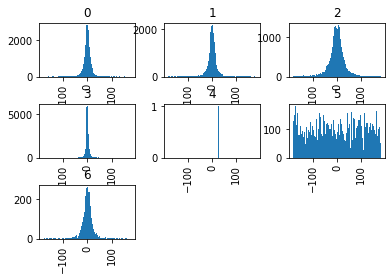

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
labels.hist(column='dirPhi', by='type', bins=100, range=[-180,180])
plt.show()

In [5]:
import numpy as np

def prediction_classifier(row):
    combined_values = [
        row["category"][0]+row["category"][2]+row["category"][4]+row["category"][6],
        row["category"][1]+row["category"][3]+row["category"][5]+row["category"][7],
        row["category"][8],
        row["category"][9]
    ]
    return np.asarray(combined_values).argmax()
        
def label_classifier(row):
    if row["category"] in [0,2,4,5]:
        return 0
    elif row["category"] in [1,3,5,7]:
        return 1
    elif row["category"] == 8:
        return 2
    elif row["category"] == 9:
        return 3
        
predictions['category_combined'] = predictions.apply(prediction_classifier, axis=1)
labels['category_combined'] = labels.apply(label_classifier, axis=1)

labels["category_combined"] = labels["category_combined"].astype('int')
predictions["category_combined"] = predictions["category_combined"].astype('int')

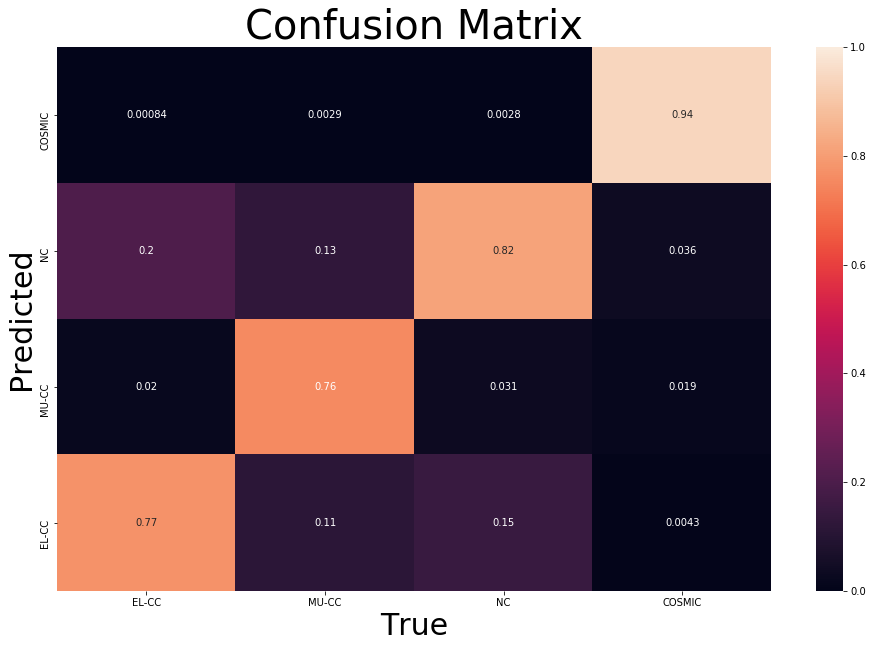

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
matrix = confusion_matrix(labels["category_combined"], predictions["category_combined"], normalize='true')
matrix_transpose = np.rot90(matrix, 1)
df_cm = pd.DataFrame(matrix_transpose, 
                     index = ["COSMIC", "NC", "MU-CC", "EL-CC"],
                     columns = ["EL-CC", "MU-CC", "NC", "COSMIC"])
plt.figure(figsize=(16,10))
sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0)
plt.title('Confusion Matrix', fontsize = 40) # title with fontsize 20
plt.xlabel('True', fontsize = 30) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 30) # y-axis label with fontsize 15
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(labels["category_combined"], predictions["category_combined"], target_names=axis_labels))

              precision    recall  f1-score   support

       EL-CC       0.68      0.77      0.72     40406
       MU-CC       0.91      0.76      0.82     40285
          NC       0.80      0.82      0.81     68889
      COSMIC       0.97      0.94      0.95     10420

    accuracy                           0.80    160000
   macro avg       0.84      0.82      0.83    160000
weighted avg       0.81      0.80      0.80    160000



In [22]:
dense_labels, dense_output = evaluators.predict_dense(data_loader.test_data(), model)

--- 77.06482458114624 seconds to test model ---


In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(dense_output)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.11412945 0.10867383 0.07467682]


In [24]:
dense_labels['category_combined'] = dense_labels.apply(label_classifier, axis=1)
dense_labels["category_combined"] = dense_labels["category_combined"].astype('int')

In [28]:
# Add in the labels
pca_df = pd.DataFrame(pca_result)
pca_df['category_combined'] = dense_labels['category_combined']
pca_df.rename(columns={0: "PCA1", 1: "PCA2", 2: "PCA3"}, inplace=True)
pca_df.head()

,PCA1,PCA2,PCA3,category_combined
0,-4.848666,7.527645,0.124513,2
1,0.495075,-3.487542,5.626025,1
2,-2.361648,-0.448669,-1.571075,2
3,-0.810847,-1.186954,2.103702,2
4,-8.247417,3.485346,0.614137,2


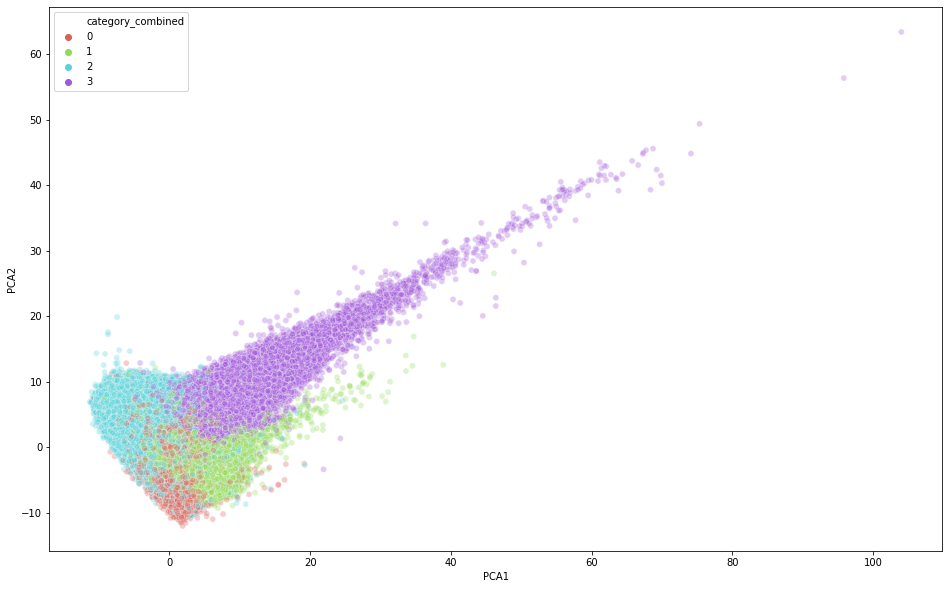

In [32]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=pca_df,
    legend="full",
    alpha=0.3
)
plt.show()

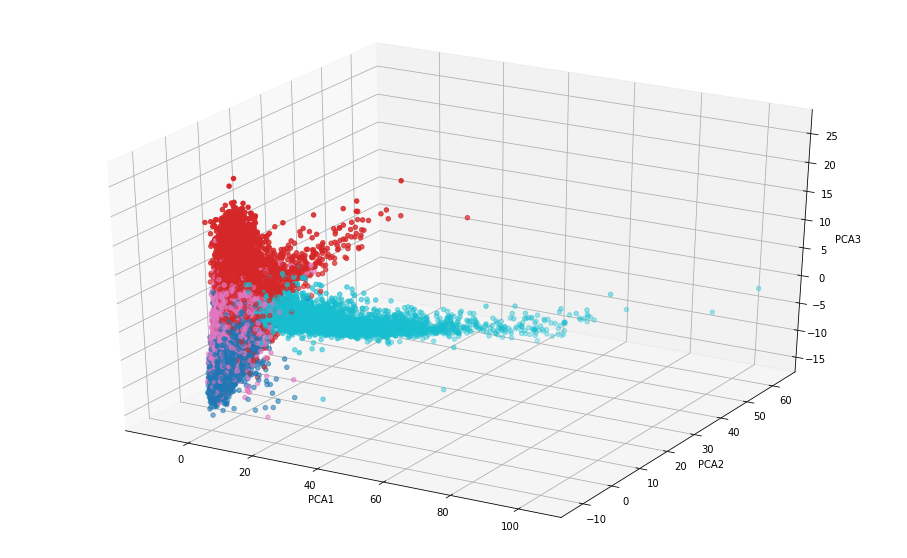

In [35]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["PCA1"], 
    ys=pca_df["PCA2"], 
    zs=pca_df["PCA3"], 
    c=pca_df["category_combined"], 
    cmap='tab10'
)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [36]:
N = 20000
dense_subset = dense_output[:N]
labels_subset = dense_labels[:N]

In [37]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 4.414s...
[t-SNE] Computed neighbors for 20000 samples in 528.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

In [38]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df['category_combined'] = labels_subset['category_combined']
tsne_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)
tsne_df.head()

,tsne-2d-one,tsne-2d-two,category_combined
0,0.370539,-5.516315,2
1,-4.587668,-0.063699,1
2,0.923863,0.318297,2
3,-3.193542,-1.390295,2
4,5.696501,-1.416846,2


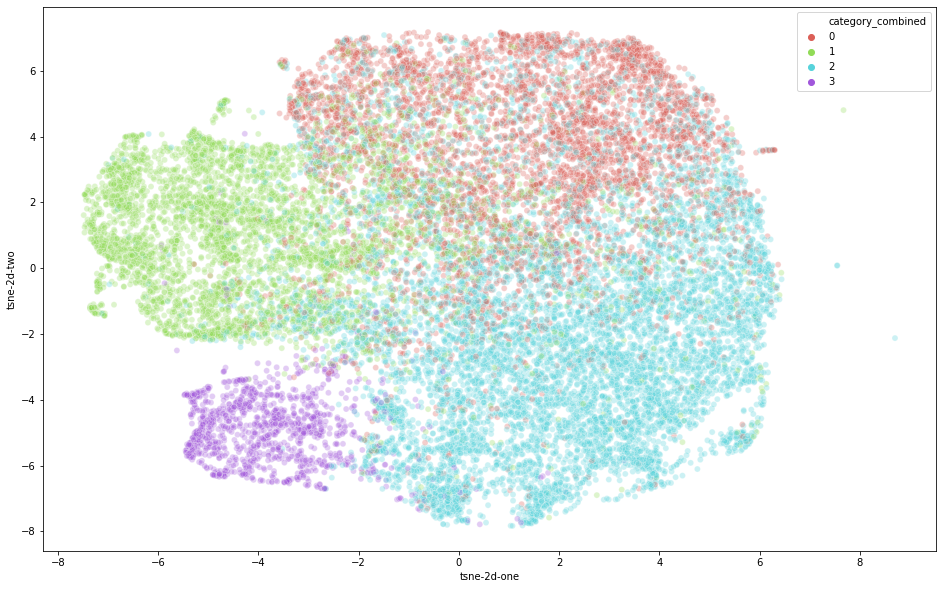

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [41]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(dense_output)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
pca_50_df = pd.DataFrame(pca_result_50)
pca_50_df.head()

Cumulative explained variation for 50 principal components: 0.7189700370439048


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-4.848948,7.527528,0.124530,-2.026206,-1.313639,-2.928722,1.324377,1.175498,-0.912737,-1.233224,...,-0.379311,0.181506,-0.030283,-0.639962,0.423294,-0.246128,-0.209528,0.146679,-0.107414,0.115795
1,0.495077,-3.487453,5.625926,-2.726327,1.356069,-1.041740,0.039107,-1.589215,-1.031638,2.291784,...,-0.170100,-0.109139,-0.906687,0.533561,0.017205,-0.022203,-0.169880,0.246116,-0.561512,-0.057246
2,-2.361640,-0.448651,-1.571161,7.790086,-0.603761,1.147310,-1.983181,-0.523196,-1.258711,-0.480931,...,-0.401222,0.154567,-0.444934,-0.365861,0.749034,0.067295,0.460116,0.035657,-0.535669,0.359250
3,-0.810847,-1.186953,2.103700,-2.408209,-0.592207,-1.846427,0.770930,-1.856655,0.125459,3.283100,...,-0.329794,-0.084514,-0.140773,0.014165,0.143807,0.633979,0.491573,0.280633,-0.236306,-0.072186
4,-8.247418,3.485348,0.614134,1.653623,4.708182,2.531397,-1.831107,-0.413911,-0.286394,0.409529,...,1.142354,-0.025849,0.342241,0.303640,-0.545827,-0.291558,0.168479,-0.992144,-0.365560,-0.186682


In [42]:
N = 20000
pca_50_subset = pca_50_df[:N]
labels_50_subset = dense_labels[:N]

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.140s...
[t-SNE] Computed neighbors for 20000 samples in 40.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

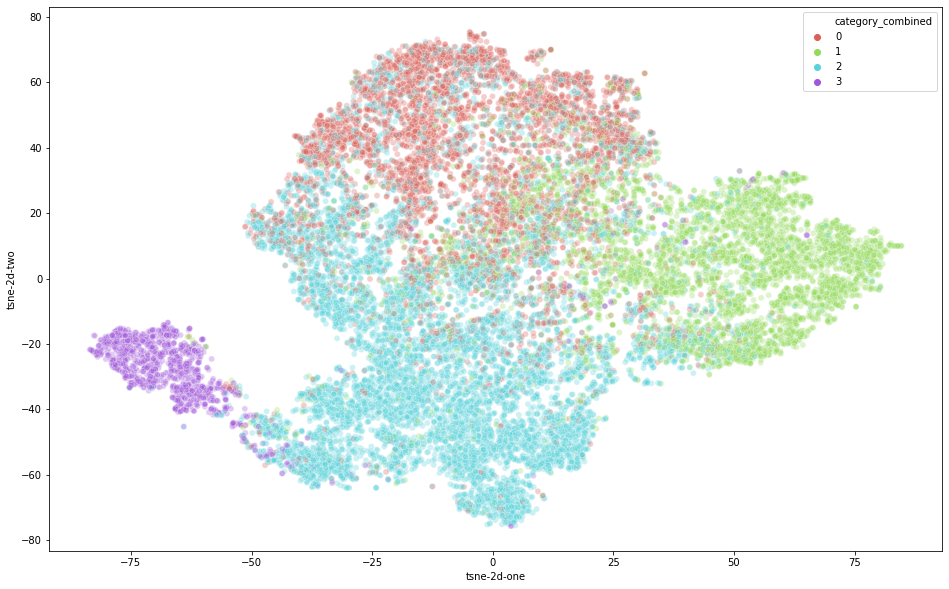

In [44]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000, learning_rate=1000.0, early_exaggeration=12.0)
tsne_results_50 = tsne.fit_transform(pca_50_subset)

tsne_50_df = pd.DataFrame(tsne_results_50)
tsne_50_df['category_combined'] = labels_50_subset['category_combined']
tsne_50_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_50_df,
    legend="full",
    alpha=0.3
)